## Measuring the effect of DKG grounding via model comparison

**Introduction**: When comparing models, MIRA finds exact equivalences between concepts (analogous to "states" in Petri nets or "stocks" in stock and flow models) or ontological refinements between them. MIRA then extends these comparisons to the template level (analogous to "transition" in Petri nets or "flow" in stock and flow models) to find equivalences or refinements. The result of this comparison is summarized as a graph which can be visualized to show the relationship of the two models, as well as a heuristic similarity score between 0 and 1 with 0 corresponding to no relation and 1 corresponding to exact equivaence.

**Model comparison method**: When MIRA compares concepts, in case the concepts have grounding (which are generally terms from the DKG), the grounding is used to do comparison. If grounding is not available, the string name of the concept is used for comparison. For example, assume one model has a concept called "S" and another, a concept called "Susceptible". The name-based comparison would conclude that these are not the same, whereas if both concepts were grounded to the DKG term "ido:0000514", they would be considered equal. An example of refinement is, for instance, when one model has an "Infected" concept grounded to "ido:0000511", and another model has "Infected_Asymptomatic", grounded to "ido:0000511" with context "ncit:C3833" (asymptomatic). Here, "Infected_Asymptomatic" would be a refinement of "Infected".

**Approach to measuring impact of grounding**: Given the above, we expect that if models "in the wild" are using consistent naming conventions are align with each other in simple ways (i.e., refinements are not common), model comparison without using grounding would work sufficiently well just based on string names. If, however, grounding plays an important role, we will be able to observe that model comparison graphs and model similarity scores will differ between the conditions where we use grounding and when we ignore it.

**Model set**: The BioModels database contains a number of published COVID-19 models. Each of these models is available in a structured format: SBML. We first process 6 of the models to compute pairwise similarity scores with and without grounding (this allows us to show all the results in a table that wouldn't be possible for the broader model set due to the large number of pairwise comparisons). We then extend the analysis to all pairs of 24 models and present statistics of how similarity scores change. In the first round of analysis we look at six selected models available [here](https://www.ebi.ac.uk/biomodels/covid-19).

In [1]:
import time
from copy import deepcopy
from tabulate import tabulate

import pandas as pd
import matplotlib.pyplot as plt

from mira.sources import biomodels
from mira.metamodel import *

%env MIRA_REST_URL=http://mira-epi-dkg-lb-dc1e19b273dedaa2.elb.us-east-1.amazonaws.com
rc = get_dkg_refinement_closure()

env: MIRA_REST_URL=http://mira-epi-dkg-lb-dc1e19b273dedaa2.elb.us-east-1.amazonaws.com


In [2]:
SUBSET_MODEL_LIST = ["BIOMD0000000955", "BIOMD0000000956", "BIOMD0000000957",
                     "BIOMD0000000958","BIOMD0000000960","BIOMD0000000962"]

tm_covid_subset_grounding_list = []
for covid_model in SUBSET_MODEL_LIST:
    tm_covid_subset_grounding_list.append(biomodels.get_template_model(covid_model))

model_id_subset_name_mapping = {id: tm.annotations.name.split(' ')[0]
                                for id,tm in enumerate(tm_covid_subset_grounding_list)}

## Similarity scores for initial model pairs with DKG grounding

We convert the subset of COVID-19 biomodels into MIRA template models. We then compute pairwise similarity scores between each grounded model.

Similarity scores between template models are calculated by comparing the concepts of each template model. First, we sum up equivalences and refinements: if two concepts are equivalent, then we add 1 to the sum, if one template model's concept is a reinfement of the other template model's concept, we add 0.5 to the sum. We then normalize this sum by dividing it by the number of nodes in the larger template model to get the overall score. This is a simple heuristic that works well for ranking by similarity.

Below we show a table of all similarity scores (with grounding) for pairs of the 6 selected models. 

In [3]:
tm_covid_subset_comparison = TemplateModelComparison(tm_covid_subset_grounding_list,
                                                     refinement_func=rc.is_ontological_child)
grounded_scores = tm_covid_subset_comparison.model_comparison.get_similarity_scores()

grounded_scores_df_list = [{'Model1': model_id_subset_name_mapping[d['models'][0]],
                            'Model2': model_id_subset_name_mapping[d['models'][1]],
                            'Similarity Score': d['score']} for d in grounded_scores]
df_grounded = pd.DataFrame(grounded_scores_df_list)
df_grounded

Comparing model templates: 946it [00:00, 119927.81it/s]
Comparing model concepts: 595it [00:00, 203076.81it/s]


,Model1,Model2,Similarity Score
0,Giordano2020,Bertozzi2020,0.6250
1,Giordano2020,Roda2020,0.7500
2,Giordano2020,Ndairou2020,0.4375
3,Giordano2020,Paiva2020,0.4375
4,Giordano2020,Zhao2020,0.4375
5,Bertozzi2020,Roda2020,0.8750
6,Bertozzi2020,Ndairou2020,0.5000
7,Bertozzi2020,Paiva2020,0.4375
8,Bertozzi2020,Zhao2020,0.6250
9,Roda2020,Ndairou2020,0.5000


## Drilling down into a specific example
We visualize the difference between the third (BIOMD0000000957) and sixth (BIOMD0000000962) grounded covid models

Below, the graph can be interpreted as follows:
- Orange nodes: exact equivalence between concepts
- Green nodes: one of the models' templates (rectangle) and concepts (oval)
- Blue nodes: the other model's tempaltes (rectangle) and concepts (oval)
- Red arrows: refinement relationship between pairs of concepts or templates

As can be seen below, this comparison is **using** DKG groundings, these are shown in each node.

In [4]:
print(tm_covid_subset_comparison.template_models[2].annotations.name)
print(tm_covid_subset_comparison.template_models[5].annotations.name)

Roda2020 - SIR model of COVID-19 spread in Wuhan
Zhao2020 - SUQC model of COVID-19 transmission dynamics in Wuhan, Hubei, and China


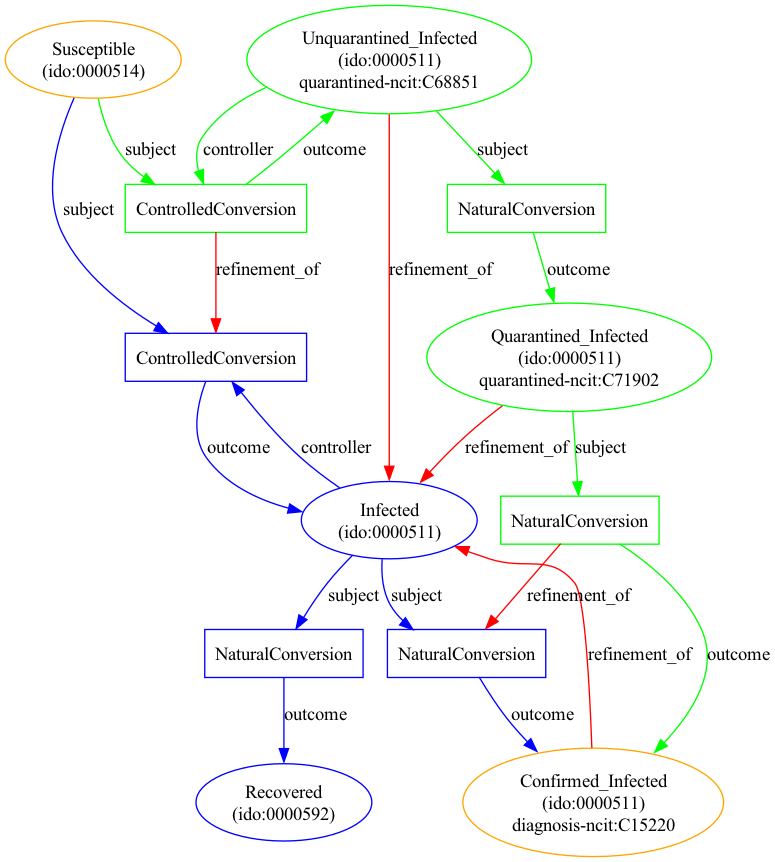

In [5]:
TemplateModelDelta.for_jupyter(tm_covid_subset_comparison.template_models[2],
                               tm_covid_subset_comparison.template_models[5],
                               rc.is_ontological_child,
                               args="-Grankdir=TB")

## Similarity scores without DKG grounding for initial model pairs

When removing groundings from each template model, we expect the pair-wise template model similarity scores to potentially change due to any of the following factors:
- refinements dissapearing
- equivalences not recognized due to differing naming conventions
- false equivalences recognized due to overlapping names for non-equal concepts

Below, we re-run model comparison for ungrounded models and present a table summarizing the similarity scores with and without grounding.

In [6]:
tm_covid_subset_no_grounding_list = [] 
for tm in tm_covid_subset_grounding_list:
    copied_tm = deepcopy(tm)
    for template in copied_tm.templates:
        for concept in template.get_concepts():
            concept.identifiers = {}
            concept.context = {}
    tm_covid_subset_no_grounding_list.append(copied_tm)

In [7]:
tm_covid_subset_comparison_copy = TemplateModelComparison(tm_covid_subset_no_grounding_list,
                                                          refinement_func=rc.is_ontological_child)
ungrounded_scores = tm_covid_subset_comparison_copy.model_comparison.get_similarity_scores()

list_of_both_subset = []

for grounded_score,ungrounded_score in zip(grounded_scores,ungrounded_scores):
    list_of_both_subset.append(
        {'Model1': model_id_subset_name_mapping[grounded_score['models'][0]],
         'Model2': model_id_subset_name_mapping[grounded_score['models'][1]],
         'Similarity Score with Grounding': grounded_score['score'],
         'Similarity Score without Grounding': ungrounded_score['score']}
    )
                    

no_ground_df = pd.DataFrame(list_of_both_subset)
no_ground_df

Comparing model templates: 946it [00:00, 156545.87it/s]
Comparing model concepts: 595it [00:00, 235279.62it/s]


,Model1,Model2,Similarity Score with Grounding,Similarity Score without Grounding
0,Giordano2020,Bertozzi2020,0.6250,0.250
1,Giordano2020,Roda2020,0.7500,0.250
2,Giordano2020,Ndairou2020,0.4375,0.125
3,Giordano2020,Paiva2020,0.4375,0.125
4,Giordano2020,Zhao2020,0.4375,0.125
5,Bertozzi2020,Roda2020,0.8750,0.750
6,Bertozzi2020,Ndairou2020,0.5000,0.250
7,Bertozzi2020,Paiva2020,0.4375,0.250
8,Bertozzi2020,Zhao2020,0.6250,0.250
9,Roda2020,Ndairou2020,0.5000,0.250


## Drilling down into the same example model pair without groundings

We previously showed an example model comparison graph with groundings. Below we show the comparison of the same two models without grounding. We observe that "Susceptible" was still correctly recognized as equivalent due to name matches but all refinements and one additional equivalence was missed.

This explains the change in similarity scores with and without grounding, as printed below the graph.

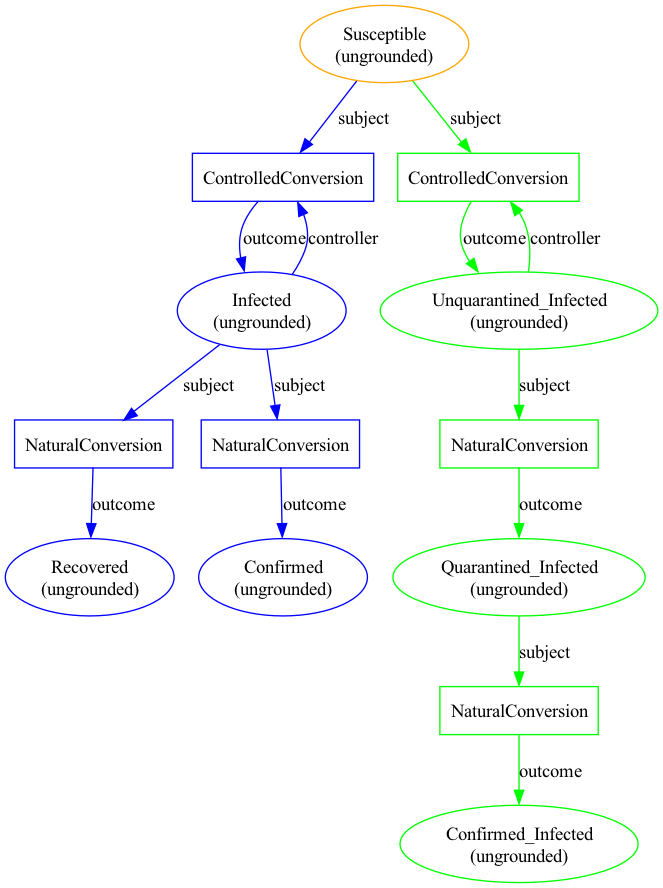

In [8]:
TemplateModelDelta.for_jupyter(tm_covid_subset_comparison_copy.template_models[2],
                               tm_covid_subset_comparison_copy.template_models[5],
                               rc.is_ontological_child,
                               args="-Grankdir=TB")

In [9]:
print(f"The similarity score between models 2 and 5 when grounded is {grounded_scores[11]['score']}. "
      f"The similarity score between the models when ungrounded is "
      f"{list_of_both_subset[11]['Similarity Score without Grounding']}.")

The similarity score between models 2 and 5 when grounded is 0.625. The similarity score between the models when ungrounded is 0.25.


## Summary statistics of score changes for the 6 initial models

In [10]:
lower_count = 0 
higher_count = 0
same_count = 0
for model_comparison in list_of_both_subset:
    if (model_comparison['Similarity Score without Grounding'] < 
            model_comparison['Similarity Score with Grounding']):
        lower_count += 1
    elif (model_comparison['Similarity Score without Grounding'] > 
              model_comparison['Similarity Score with Grounding']):
        higher_count += 1
    elif (model_comparison['Similarity Score without Grounding'] == 
              model_comparison['Similarity Score with Grounding']):
        same_count += 1
        
print(f"Out of {len(list_of_both_subset)} pairs of models, {lower_count} pairs of models have "
      f"reduced similarity scores with groundings removed. {higher_count} pairs of models have "
      f"increased similarity scores without groundings. {same_count} pairs of models have the "
      f"same similarity scores with groundings removed.")

Out of 15 pairs of models, 12 pairs of models have reduced similarity scores with groundings removed. 0 pairs of models have increased similarity scores without groundings. 3 pairs of models have the same similarity scores with groundings removed.


## Statistics of score changes over all COVID-19 models

We now expand the analysis to compute pairwise similarity scores between 24 of the COVID-19 models in the BioModels database. 

The entire database of models can be found [here](https://www.ebi.ac.uk/biomodels/search?query=submitter_keywords:COVID-19&domain=biomodels). 

The comparison table is too long to present so we calculate summary statistics of the differences with and without grounding between the similarity scores.

In [11]:
ALL_MODEL_LIST = ["BIOMD0000000955", "BIOMD0000000956", "BIOMD0000000957", "BIOMD0000000958",
                  "BIOMD0000000960", "BIOMD0000000962", "BIOMD0000000963", "BIOMD0000000964",
                  "BIOMD0000000969", "BIOMD0000000970", "BIOMD0000000971", "BIOMD0000000972",
                  "BIOMD0000000974", "BIOMD0000000976", "BIOMD0000000977", "BIOMD0000000978",
                  "BIOMD0000000979", "BIOMD0000000980", "BIOMD0000000981", "BIOMD0000000982",
                  "BIOMD0000000983", "BIOMD0000000984", "BIOMD0000000988", "BIOMD0000000991"]

In [12]:
tm_covid_all_grounding_list = []
for covid_model in ALL_MODEL_LIST:
    tm_covid_all_grounding_list.append(biomodels.get_template_model(covid_model))

model_id_all_name_mapping = {id:tm.annotations.name.split(' ')[0]
                             for id,tm in enumerate(tm_covid_all_grounding_list)}

In [13]:
ts = time.time()
tm_covid_all_comparison = TemplateModelComparison(tm_covid_all_grounding_list,
                                                  refinement_func=rc.is_ontological_child)
all_grounded_scores = tm_covid_all_comparison.model_comparison.get_similarity_scores()
te = time.time()
print(f"Comparing {len(all_grounded_scores)} pairs of models took {round(te-ts, 2)} seconds")

Comparing model templates: 22791it [00:00, 109978.70it/s]
Comparing model concepts: 14196it [00:00, 206874.97it/s]


Comparing 276 pairs of models took 0.45 seconds


In [14]:
tm_covid_all_no_grounding_list = [] 
for tm in tm_covid_all_grounding_list:
    copied_tm = deepcopy(tm)
    for template in copied_tm.templates:
        for concept in template.get_concepts():
            concept.identifiers = {}
            concept.context = {}
    tm_covid_all_no_grounding_list.append(copied_tm)

In [15]:
tm_covid_all_comparison_copy = TemplateModelComparison(tm_covid_all_no_grounding_list,
                                                       refinement_func=rc.is_ontological_child)
all_ungrounded_scores = tm_covid_all_comparison_copy.model_comparison.get_similarity_scores()

list_of_both_all = []
for grounded_score,ungrounded_score in zip(all_grounded_scores,all_ungrounded_scores):
    list_of_both_all.append({'Model1':model_id_all_name_mapping[grounded_score['models'][0]],
                         'Model2':model_id_all_name_mapping[grounded_score['models'][1]],
                         'Similarity Score with Grounding':grounded_score['score'],
                        'Similarity Score without Grounding':ungrounded_score['score']})

Comparing model templates: 22791it [00:00, 133258.77it/s]
Comparing model concepts: 14196it [00:00, 241374.82it/s]


In [16]:
after_sim_lower_count = 0
after_sim_higher_count = 0
after_sim_same = 0 
for model_comparison in list_of_both_all:
    if (model_comparison['Similarity Score without Grounding'] < 
            model_comparison['Similarity Score with Grounding']):
        after_sim_lower_count += 1
    elif (model_comparison['Similarity Score without Grounding'] > 
              model_comparison['Similarity Score with Grounding']):
        after_sim_higher_count += 1
    elif (model_comparison['Similarity Score without Grounding'] == 
              model_comparison['Similarity Score with Grounding']):
        after_sim_same += 1

## Summary statistics of score changes
A summary of score decreases/increases/no change is printed below. Interestingly, we found at least one example where the score did not change but there was actually a change in the comparison graph (one equivalence missed, one falsely added without grounding, resulting in an overall unchanged score).

These statistics clearly show that groundings play an important role since overwhelmingly we get different comparison results when removing groundings.

In [17]:
print(f"Removing groundings led to a decrease in pairwise similarity scores for "
      f"{after_sim_lower_count} or {round(after_sim_lower_count /len(list_of_both_all), 2)*100}% "
      f"of the {len(list_of_both_all)} pairwise model comparisons.")

Removing groundings led to a decrease in pairwise similarity scores for 231 or 84.0% of the 276 pairwise model comparisons.


In [18]:
print(f"Removing groundings led to an increase in pairwise similarity scores for "
      f"{after_sim_higher_count} or {round(after_sim_higher_count/len(list_of_both_all), 2)*100}% "
      f"of the {len(list_of_both_all)} pairwise model comparisons.")

Removing groundings led to an increase in pairwise similarity scores for 11 or 4.0% of the 276 pairwise model comparisons.


In [19]:
print(f"Removing groundings led to no change in pairwise similarity scores for "
      f"{after_sim_same} or {round(after_sim_same/len(list_of_both_all), 2) * 100}% "
      f"of the {len(list_of_both_all)} pairwise model comparisons.")

Removing groundings led to no change in pairwise similarity scores for 34 or 12.0% of the 276 pairwise model comparisons.


In [20]:
diffs = []
for model_comparison in list_of_both_all:
    diffs.append(model_comparison['Similarity Score with Grounding'] -
                 model_comparison['Similarity Score without Grounding'])

## Plot the distribution of score changes
We now show the distribution of score changes to quantify the magnitude of change as box plots summarizing the underlying distribution. The first plot shows the actual score changes, the second plot the absolute value of score changes.

(0.5, 1.5)

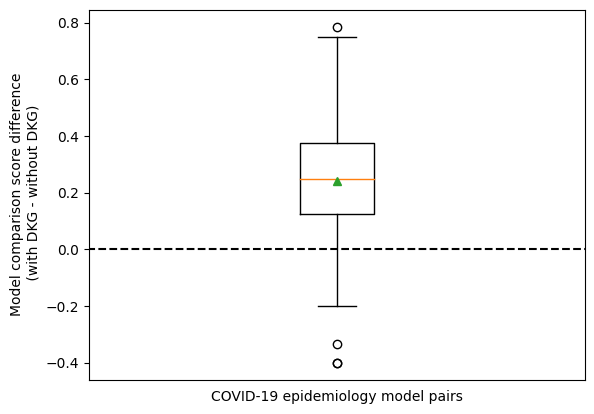

In [21]:
plt.boxplot(diffs, showmeans=True)
plt.ylabel('Model comparison score difference\n (with DKG - without DKG)')
plt.xlabel('COVID-19 epidemiology model pairs')
plt.xticks([])
plt.plot([-1, 2], [0, 0], 'k--')
plt.xlim([0.5, 1.5])

(0.5, 1.5)

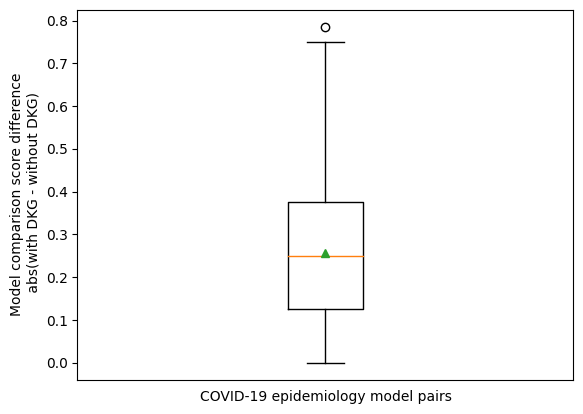

In [22]:
plt.boxplot([abs(d) for d in diffs], showmeans=True)
plt.ylabel('Model comparison score difference\n abs(with DKG - without DKG)')
plt.xlabel('COVID-19 epidemiology model pairs')
plt.xticks([])
plt.xlim([0.5, 1.5])